In [280]:
reset()
import numpy as np
from scipy.optimize import fsolve, root, minimize
from sage.symbolic.expression import Expression
%display latex

# Modelo

In [281]:
class No:
    """Define as propriedades de um nó."""
    
    def __init__(self, idt, x, y, fx=0, fy=0, fxy=0, rx=False, ry=False, rxy=False):
        """
        Args:
            idt: Identificação do nó (começa em 0).
            x: Coordenada x.
            y: Coordenada y.
            fx: Força externa na direção x.
            fy: Força externa na direção y.
            fxy: Momento esterno em torno de xy.
            rx: Restrição ao deslocamento na direção x. 'True' para restrito e 'False' para livre.
            ry: Restrição ao deslocamento na direção y. 'True' para restrito e 'False' para livre.
            rxy: Restrição à rotação em torno de xy. 'True' para restrito e 'False' para livre.
        """
        self.idt = idt
        self.x = x
        self.y = y
        self.fx = fx
        self.fy = fy
        self.fxy = fxy
        self.rx = rx
        self.ry = ry
        self.rxy = rxy
    
    def gls(self):
        """Retorna os graus de liberdade do nó."""
        return np.array([3*self.idt - 2, 3*self.idt - 1, 3*self.idt])
    
    def distancia(self, other):
        """Retorna a distância entre dois nós."""
        return sqrt(((other.x - self.x)**2 + (other.y - self.y)**2))
    
    def forcas_externas(self):
        """Retorna o vetor de forças externas atuantes no nó."""
        return [var(f'f_x{self.idt}') if self.rx else self.fx,
                var(f'f_y{self.idt}') if self.ry else self.fy,
                var(f'f_xy{self.idt}') if self.rxy else self.fxy]
    
    def deslocamentos(self):
        """Retorna o vetor de deslocamentos do nó."""
        return [0 if self.rx else var(f'u{self.idt}'),
                0 if self.ry else var(f'w{self.idt}'),
                0 if self.rxy else var(f'theta{self.idt}')]
    
    def gls_impedidos(self):
        """Retorna os graus de liberdade impedidos."""
        gls_no = self.gls()
        gls_imp = []
        
        if self.rx:
            gls_imp.append(gls_no[0])
        if self.ry:
            gls_imp.append(gls_no[1])
        if self.rxy:
            gls_imp.append(gls_no[2])
        
        return gls_imp
    
    def gls_livres(self):
        """Retorna os graus de liberdade livres."""
        return np.setdiff1d(self.gls(), self.gls_impedidos()).tolist()
    
    def no_carregado(self):
        """Retorna 'True' se o nó for carregado e 'False' se não for."""
        return bool((self.fx != 0) or (self.fy != 0) or (self.fxy != 0))
    
    def incrementar_carga(self, iteracoes):
        """Incrementa """
    
    def variaveis(self):
        """Retorna as variáveis simbólicas relacionadas ao nó."""
        vs = 0
        lv = [self.forcas_externas(), self.deslocamentos()]
        for i in lv:
            vs += sum(i)
            
        return list(vs.variables())

In [282]:
class Material:
    """Define as propriedades do material."""
    
    def __init__(self, idt, E, nu=0.2):
        """
        Args: 
            idt: Identificação do material.
            E: Módulo de elasticidade.
            nu: Coeficiente de Poisson.
        """
        self.idt = idt
        self.E = E
        self.nu = nu        
    
    def G(self):
        """Retorna o módulo de cisalhamento."""
        return self.E / (2*(1 + self.nu))        

In [283]:
class Elemento:
    """Define as propriedades de um elemento."""
    
    def __init__(self, idt, no1, no2, b, h, material, plasticidade=False):
        """
        Args:
            idt: Identificação do elemento (começa em 0).
            no1: Nó inicial.
            no2: Nó final.
            b: Comprimento da base da seção
            h: Altura da seção.
            material: Material do qual o elemento é composto.
            plastificacao: Considera os efeitos da plastificação do material nas relações 
                constitutivas.
        """
        self.idt = idt
        self.no1 = no1
        self.no2 = no2
        self.b = b
        self.h = h
        self.material = material
        self.plasticidade = plasticidade
    
    def angulo(self):
        """Retorna o ângulo de inclinação do elemento."""
        return atan2(self.no2.y - self.no1.y, self.no2.x - self.no1.x)
        
    def comprimento(self):
        """Retorna o comprimento do elemento."""
        return self.no1.distancia(self.no2)
    
    def area(self):
        """Retorna a área da seção transversal."""
        return self.b * self.h
    
    def ix(self):
        """Retorna o momento de inércia da seção em relação ao centroide."""
        return self.b * self.h**3 / 12
    
    def gls(self):
        """Retorna os graus de liberdade do elemento."""
        return np.concatenate((self.no1.gls(), self.no2.gls()))
    
    def deformacoes(self):
        """Retorna o vetor de deformações simbolicas do elemento."""
        return vector([var(f'phi{self.idt}{self.no1.idt}'),
                       var(f'phi{self.idt}{self.no2.idt}'),
                       var(f'delta{self.idt}')])
    
    def deformacoes_plasticas(self):
        """Retorna o vetor simbólico de deformações plásticas (permanentes) do elemento."""
        return vector([var(f'phi_p{self.idt}{self.no1.idt}'),
                       var(f'phi_p{self.idt}{self.no2.idt}'),
                       0])
    
    def deslocamentos(self):
        """Retorna o vetor de deslocamentos do elemento."""
        return vector(self.no1.deslocamentos() + self.no2.deslocamentos())
        
    def esforcos_internos(self):
        """Retorna o vetor de deformações simbolicas do elemento."""
        return vector([var(f'm{self.idt}{self.no1.idt}'),
                       var(f'm{self.idt}{self.no2.idt}'),
                       var(f'n{self.idt}')])
    
    def B(self):
        """Retorna a matriz de transformação cinemática."""
        a = self.angulo()
        s = sin(a)
        c = cos(a)
        L = self.comprimento()
        
        return Matrix([[s/L, -c/L, 1, -s/L, c/L, 0],
                       [s/L, -c/L, 0, -s/L, c/L, 1],
                       [-c, -s, 0, c, s, 0,]])
    
    def Ba(self, n):
        """Retorna a matriz de transformação cinemática expandida.
        
        Args:
            n: Número de termos que a matriz expandida possui.
        """
        ba = Matrix(RR, 3, n)
        ba[:, (self.gls() - 1).tolist()] = self.B()
        return ba
    
    def Fb(self):
        """Retorna a matriz de flexibilidade elástica de Bernoulli."""
        E = self.material.E
        Ix = self.ix()
        L = self.comprimento()
        A = self.area()
    
        return Matrix([[L/(3*E*Ix), -L/(6*E*Ix), 0],
                       [-L/(6*E*Ix), L/(3*E*Ix), 0],
                       [0, 0, L/(A*E)]])
    
    def Ft(self):
        """Retorna a parcela da matriz de flexibilidade elástica de Timoshenko."""
        L = self.comprimento()
        A = self.area()
        G = self.material.G()
        return Matrix([[1/(L*G*A), 1/(L*G*A), 0],
                      [1/(L*G*A), 1/(L*G*A), 0],
                      [0, 0, 0]])
    
    def F(self):
        """Retorna a matriz de flexibilidade elástica final."""
        return self.Fb() + self.Ft()
    
    def equacoes_cinematicas(self):
        """Retorna as equações cinemáticas."""
        return self.deformacoes() - self.B() * self.deslocamentos()
    
    def equacoes_constitutivas(self):
        """Retorna as equações constitutivas do elemento."""
        if self.plasticidade:
            return self.deformacoes() - self.deformacoes_plasticas() - self.F() * self.esforcos_internos()
        else:
            return self.deformacoes() - self.F() * self.esforcos_internos()
    
    def lei_plastica(self, m1=0, m2=0):
        """Retorna as funções de plastificação (formação das rótulas plásticas) do elemento.
        
        Args:
            m1: Momento na extremidade inicial.
            m2: Momento na extremidade final.
        """
        ############### Propriedades da Lei Plástica ###############
        my = 500
        ############################################################
        
        leis = []
        
        defs_p = self.deformacoes_plasticas()
                
        if (abs(m1) - my) < 0:
            leis.append(defs_p[0])
        else:
            # É feito o produto de mi pelo sinal de mi para que seja feita a emulação do módulo.
            # Isso simplifica a solução do sistema de equações.
            leis.append(sign(m1) * var(f'm{self.idt}{self.no1.idt}') - my)
            
        if (abs(m2) - my) < 0:
            leis.append(defs_p[1])
        else:
            leis.append(sign(m2) * var(f'm{self.idt}{self.no2.idt}') - my)
        
        return leis
    
    def variaveis(self):
        """Retorna as variáveis simbólicas relacionadas ao elemento."""
        vs = 0
        
        lv = [self.deformacoes(),
              self.esforcos_internos()]
        
        if self.plasticidade:
            lv.append(self.deformacoes_plasticas())
            
        for i in lv:
            vs += sum(i)
            
        return list(vs.variables())     
    
    def parametros_iniciais(self, Ecr, Ep, Eu, phi_pu, x0_int=[-5, 5, 100], tipo=1):
        """Retorna os parâmetros iniciais do modelo.
        
        Args:
            Ecr: Esforço de fissuração (Mcr -> Momento de fissuração ou Vcr -> Cortante de fissuração).
            Ep: Esforço de plastificação (Mp -> Momento de plastificação ou Vp -> Cortante de plastificação).
            Eu: Esforço último (Mu -> Momento último ou Vu -> Cortante último).
            phi_pu: Rotação última de plastificação (Momento) ou distorção última de plastificação (Cortante).
            x0_int: Intervalo de busca dos valores iniciais para a resolução do sistema de equações.
            tipo: 1 para os parâmetros de flexão e 2 para os parâmetros de cisalhamento.            
        
        Return:
            R0, q, c, k0
        """
        if tipo not in [1,2]:
            raise ArgumentError(f'O tipo {tipo} não é válido!')
            
        # Intervalo de busca dos valores de dp
        dp_int = [0, 0.8]
            
        E = self.material.E
        ix = self.ix()
        A = self.area()
        L = self.comprimento()
        m, d, du, R0, q, c, k0, dp, phi_p = var('m d du R0 q c k0 dp phi_p') 
        v_subs = []
        
        G = (L*m**2) / (6*E*ix*(1-d)**2)
        R = R0 + q*ln(1 - d) / (1 - d)
        
        # Cálculo de R0
        eq = (G - R)
        eq1 = eq.subs([m==Ecr, d==0]) == 0
        R0_n = solve(eq1, R0)[0].rhs().n()
        R = R.subs(R0 == R0_n)
        
        # Cálculo de q e du
        eq2 = eq.subs([m==Ecr, d==du]) == 0
        
        s_temp = solve((G - R), m)
        eq_m = m == sqrt((R)*(6*E*ix*(1-d)**2)/L)
        
        def f(x):
            eq3 = (eq_m - Eu).rhs().subs([m==Eu, q==x[0], d==x[1]])
            eq4 = eq_m.rhs().diff(d).subs([m==Eu, q==x[0], d==x[1]])
            return np.linalg.norm([eq3, eq4])
        
        res = None
        x0 = [0, 0.5]
        for x01 in np.linspace(*x0_int):
            x0[0] = x01
            try:
                res = minimize(f, x0, method='Nelder-Mead')
                break
            except Exception:
                continue
                
        if res is None:
            print("Não foi possível encontrar uma solução viável para o sistema de equações.")
            return
        
        q_n, du_n = res.x
        R = R.subs(q==q_n)
        
        # Cálculo de dp
        eq4 = (G - R).subs([m==Ep, d==dp, phi_p==0])
        dp_n = find_root(eq4, *dp_int)
        
        # Cálculo de k0
        f = (m/(1 - d) - c*phi_p) - k0
        eq5 = f.subs([m==Ep, d==dp_n, phi_p==0])
        k0_n = solve(eq5, k0)[0].rhs().n()
        f = f.subs(k0==k0_n)
        
        # Cálculo de c
        eq6 = f.subs([m==Eu, d==du_n, phi_p==phi_pu])
        c_n = solve(eq6, c)[0].rhs().n()
        
        return R0_n, q_n, c_n, k0_n

In [284]:
class Estrutura:
    """Define as propriedades de uma estrutura."""
    
    def __init__(self, nos, elementos, plasticidade=False):
        """
        Args:
            nos: Lista de nós que compõem a estrutura.
            elementos: Lista de elementos que compõem a estrutura.
        """
        self.nos = nos
        self.plasticidade = plasticidade
        
        for elm in elementos:
            elm.plasticidade = self.plasticidade
        self.elementos = elementos
        
    def num_nos(self):
        """Retorna o número de nós."""
        return len(self.nos)
    
    def num_elementos(self):
        """Retorna o número de elementos."""
        return len(self.elementos)
    
    def num_gls(self):
        """Retorna o número total de graus de liberdade da estrutura."""
        return 3 * self.num_nos()
    
    def gls_impedidos(self):
        """Retorna um vetor contendo os graus de liberdade impedidos."""
        gls = []
        for no in self.nos:
            gls += no.gls_impedidos()
        return gls
    
    def gls_livres(self):
        """Retorna os graus de liberdade livres."""
        # Cálculo da diferença entre um vetor com todos os graus de liberdade do vetor com os gls impedidos.
        gls = []
        for no in self.nos:
            gls += no.gls_livres()
        return gls    
        
    def forcas_externas(self):
        """Retorna o vetor de forças generalizadas."""
        # Criação de variáveis f11, f12,..., fn. (f12 -> força atuante no grau de liberdade 2 do nó 1) 
        fe = []
        for no in self.nos:
            fe += no.forcas_externas()
        return vector(fe)
    
    def deslocamentos(self):
        """Retorna o vetor de deslocamentos generalizados."""
        # Criação de variáveis d11, d12,..., dn. (d12 -> deslocamento no grau de liberdade 2 do nó 1) 
        desloc = []
        for no in self.nos:
            desloc += no.deslocamentos()
        return vector(desloc)
            
    def deformacoes(self):
        """Retorna uma lista contendo os vetores de deformações generalizadas por elemento."""
        # São três deformações para cada elemento.
        # Criação de variáveis phi11, phi12,..., phin. (phi12 -> primeiro valor indica a barra e o segundo a deformação.
        # 1 -> Deformação de rotação no primeiro nó do elemento.
        # 2 -> Deformação de rotação no segundo nó do elemento.
        # 3 -> Deformação de alongamento/encurtamento do elemento.
        phi = []
        for elem in self.elementos:
            phi.append(elem.deformacoes())
        return phi
    
    def esforcos_internos(self):
        """Retorna uma lista contendo os vetores de esforços internos para cada elemento."""
        # São três esforços para cada elemento.
        # Criação de variáveis m11, m12,..., mn. (m12 -> primeiro valor indica a barra e o segundo o local de atuação do esforço.
        # 1 -> momento no primeiro nó do elemento.
        # 2 -> momento no segundo nó do elemento.
        # 3 -> esforço normal.
        m = []
        for elem in self.elementos:
            m.append(elem.esforcos_internos())
        return m
    
    def equacoes_cinematicas(self):
        """Retorna as equações cinemáticas da estrutura."""
        eqs = []
        for elem in self.elementos:
            eqs += elem.equacoes_cinematicas()
        return eqs
    
    def equacoes_constitutivas(self):
        """Retorna as equações constitutivas do elemento de identificação idt."""
        eqs = []
        for elem in self.elementos:
            eqs += elem.equacoes_constitutivas()
        return eqs
    
    def equacoes_equilibrio(self):
        """Retorna as equações de equilíbrio da estrutura."""
        eqs = vector(SR, self.num_gls())
        num_gls = self.num_gls()
        
        for elem in self.elementos:
            t = elem.B().T * elem.esforcos_internos()

            for i, j in enumerate(elem.gls() - 1):
                eqs[j] += t[i]
        
        return list(eqs - self.forcas_externas())
    
    def lei_plastica(self, solucao_anterior=None):
        """Retorna as equações obtidas pela lei plástica de cada elemento."""
        lp = []
        
        if solucao_anterior is None:
            for elem in self.elementos:
                lp += elem.lei_plastica()
        else:
            for elem in self.elementos:
                m1 = self.extrair_variavel(var(f'm{elem.idt}{elem.no1.idt}'), solucao_anterior)
                m2 = self.extrair_variavel(var(f'm{elem.idt}{elem.no2.idt}'), solucao_anterior)
                lp += elem.lei_plastica(m1, m2)

        return lp
    
    def equacoes(self, solucao_anterior=None):
        """Retorna uma lista contendo todas as equações do problema."""
        eqs = self.equacoes_cinematicas() + self.equacoes_constitutivas() + self.equacoes_equilibrio()
        
        if self.plasticidade:
            eqs += self.lei_plastica(solucao_anterior)
        
        return eqs
    
    def resolucao_sistema(self, solucao_anterior=None):
        """Retorna a resolução do sistema de equações."""
        return solve(self.equacoes(solucao_anterior), self.variaveis())[0]
    
    def extrair_variavel(self, variavel, vetor_solucao):
        """Extrai o valor de uma variável do vetor de soluções."""
        for i in vetor_solucao:
            if i.has(variavel):
                return i.rhs()
        print('Variável não encontrada!')

    def variaveis(self):
        """Retorna todas as variáveis simbólicas do problema."""
        vs = []
        
        for no in self.nos:
            vs += no.variaveis()
        
        for elem in self.elementos:
            vs += elem.variaveis()
        
        return vs
    
    def solucao_plastica(self, iteracoes=100):
        """Retorna a solução do problema considerando-se os efeitos da plasticidade."""
        # Cópia dos nós carregados
        nos_carregados_copia = []
        resultados = {}
        
        for i in self.variaveis():
            resultados[i] = []
        
        for no in self.nos:
            if no.no_carregado():
                nos_carregados_copia.append(copy(no))
                
                resultados[var(f'f_x{no.idt}')] = []
                resultados[var(f'f_y{no.idt}')] = []
                resultados[var(f'f_xy{no.idt}')] = []
                
        r = None
        
        for i in range(1, iteracoes + 1):
            f = []
            p = i / iteracoes
            c = 0
            for no in self.nos:
                if no.no_carregado():
                    no_copia = nos_carregados_copia[c]
                    no.fx = p * no_copia.fx
                    no.fy = p * no_copia.fy
                    no.fxy = p * no_copia.fxy
                    
                    resultados[var(f'f_x{no.idt}')].append(no.fx)
                    resultados[var(f'f_y{no.idt}')].append(no.fy)
                    resultados[var(f'f_xy{no.idt}')].append(no.fxy)
                    
                    c += 1
                    
            r = self.resolucao_sistema(r)
            solucao_anterior = copy(r)
            
            for j in r:
                resultados[j.lhs()].append(j.rhs())
            
        return resultados
        

# Montagem do problema

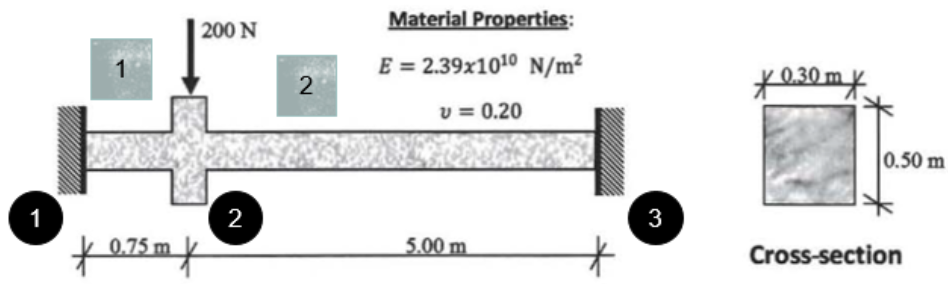

### Estrutura

In [286]:
# ========== Nós ==========
nos = [No(1, 0, 0, rx=True, ry=True, rxy=True),
       No(2, 0, 800, fx=277.778)]

# ========== Material ==========
E = 24.5
nu = 0.2

material = Material(1, E, nu)

# ========== Elementos ==========
b = 250
h = 250

elementos = [Elemento(1, nos[0], nos[1], b, h, material)]

# ========== Estrutura ==========
estrutura = Estrutura(nos, elementos, plasticidade=True)

In [288]:
# Ecr, Ep, Eu, phi_pu, x0=[-0.5, 0.5], tipo=1)
t = elementos[0].parametros_iniciais(115.758, 529.74, 635.688, 0.52875e-1, [-2, 0.5, 100])
t

(0.000224024694098547,
 -0.018281152336058572,
 18040.5816837809,
 758.431666658728)

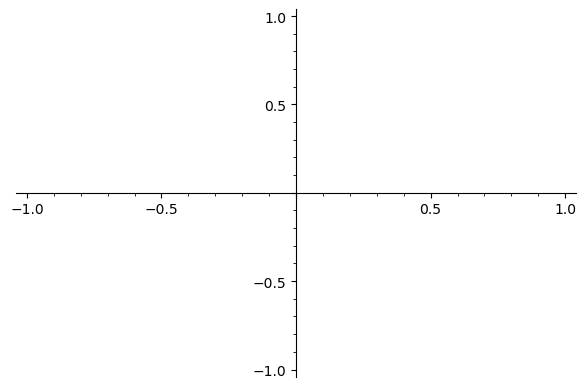

In [69]:
p = [[abs(i), abs(j)] for i, j in zip(s[var('w2')], s[var('f_y2')])]
list_plot(p, plotjoined=True)

In [46]:
# Cortante
vi = vj = (mi + mj) / L
# Matriz de flexibilidade adicional por fissuras de flexão C
# Relação de aspecto
# Taxa de armadura transversal

NameError: name 'mi' is not defined

In [173]:
t = -15/87 + 36*var('x')

In [174]:
t

36*x - 5/29

In [177]:
any(sign(i) == -1 for i in t.operands())

True